# Week 2 Machine Learning Exercises

### Hello!  And welcome to Week 2 of TCSS600 (Independent Study of Machine Learning)!  This week we will be pivoting to multilayer artificial neural networks.  There are three main deliverables this week:

(1) First, we will build a a simple artificial network that can classify handwritten digits of the MNIST dataset WITHOUT using any Python ML libraries.  This will be to deliberately learn more about backpropagation and neural network training.

(2) Second, we will run through some practical exercises to learn more about Pytorch.  We will follow a handful of exercises in the textbook -Machine Learning with PyTorch and Scikit-Learn.- 

(3) Finally, We will revist the Iris dataset from Week 1, but this time we will use the Pytorch library and repeat those exercises to gain an appreciation of Pytorch's functionality.

# THE MNIST DATASET

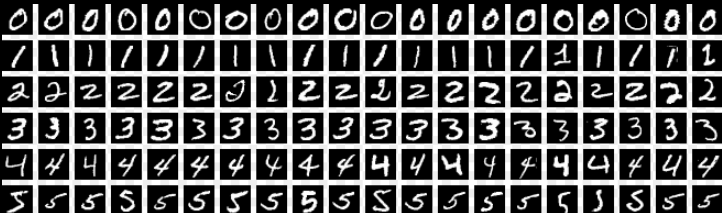

#### The MNIST dataset (Modified National Institute of Standards and Technology) is a classic tool used in machine learning.  It is especially useful for teaching concepts behind image classification and computer vision. It contains 70,000 grayscale images of handwritten digits from 0 to 9, each sized 28×28 pixels. Of these, 60,000 are used for training and 10,000 for testing.

#### Each image is labeled with the correct digit, making MNIST a supervised learning dataset. The simplicity of the images combined with their consistent formatting makes it ideal for testing algorithms in classification, feature extraction, and deep learning.  The dataset is easy to load, quick to train on, and still challenging enough to demonstrate meaningful results.

#### Today we will teach my laptop how to "read" handwritten digits!

# Quick Recap on Single-Layer Neural Networks!

#### I love this one page summary on single-layer neural networks.

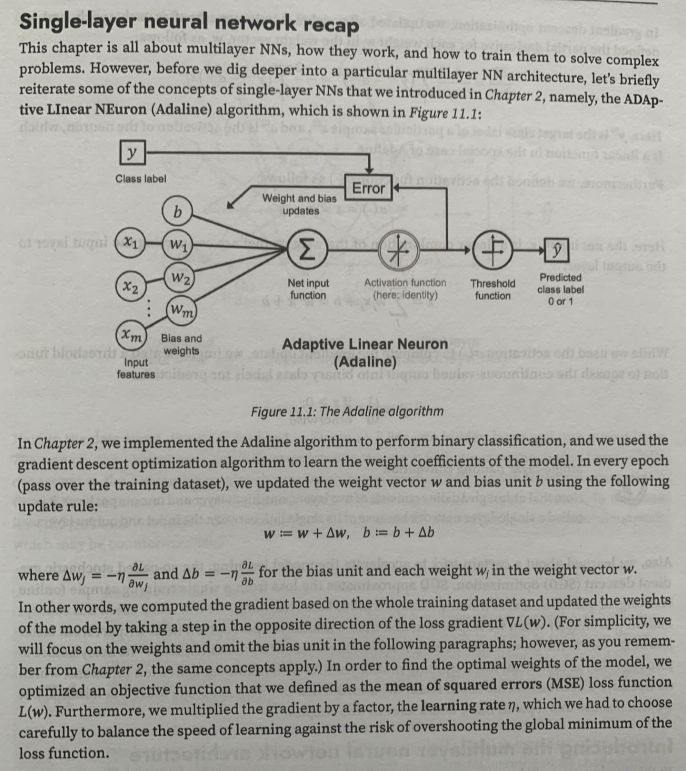

# Now introducing a multilayer perceptron (MLP)!!!!!

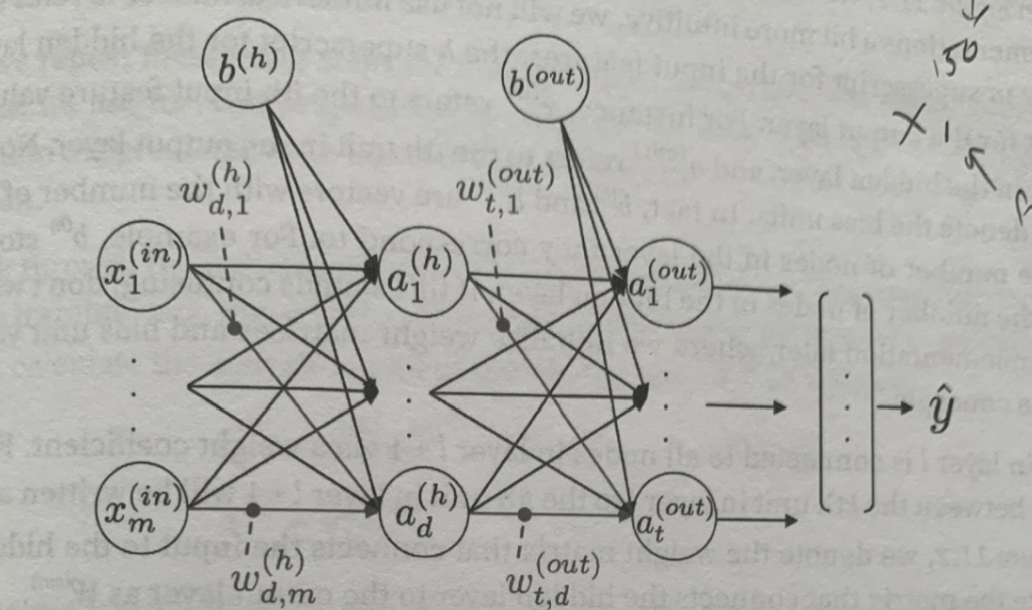

#### "x" represents the dimensions of the input, "a" reprecesent the activation of the neuron.  In week 1 this was a linear function that "fired" when a certain threshold was met. "(h)" represents the "hidden" layer.  "b" is the bias at each layer where the cardinality of b matches the number of nodes in that layer.

#### One thing I believe the textbook glossed over is the benefit of a MLP over a single neural network.  A single neural network, like the perceptron from Week 1, can only achieve linear seperable results.  A MLP can apply nonlinear activation functions (i.e. sigmoid) and address more complex patterns.  

## Dowload the MNIST Dataset

In [1]:
import sys
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### So what we've done here is used scikit-learn's fetch_openml function to download the MNIST dataset.  They are stored as pandas DataFrame and Series objects.  This is also neat.  We think of pictures as two dimensional grids, but here fetch_openml unrolled the 28x28 pixels into one-dimensional row vectors.

#### Let's normalize the pixel values (i.e. the grayscale intensity value) to the range -1 to 1.  This will make gradient-based optimization much easier.  Then let's pull the first five images and plot them so we can see what we have.

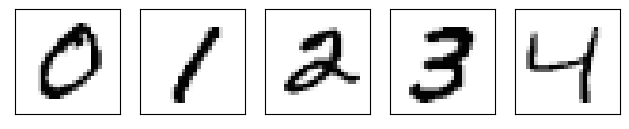

In [3]:
X = ((X / 255.) - .5) * 2
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(5):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Let's also take a look at multiple examples of a single character so we can see variations in the handwriting.

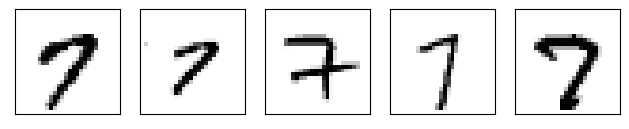

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(5):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

#### We will now divide the dataset into training, validation, and test subsets.  We will use 55,000 images for training, 5,000 for validation, and 10,000 for testing.

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


#### Let's create two helper functions.  The first is for the sigmoid and the second is to take the classification labels and turn them into vectors.  The textbook calls this "one hot encoded labels."  We need this because we have 10 total classifications. 

In [6]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

#### We will have to deviate from the textbook and put all of the methods for the NeuralNetMLP into one cell.  The model doesn't run unless we do it this way.  Note that we begin by randomizing the weights and bias.  

#### The forward layer is takes in one or more training examples and returns predictions. It also returns both the activation values from the hidden layer and the output layer, a_h and a_out. a_out represents class-membership probabilities we can convert to class labels.



In [7]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

                #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)
    

#### Here is a greate image of the MLP neural network we will instantiate. 

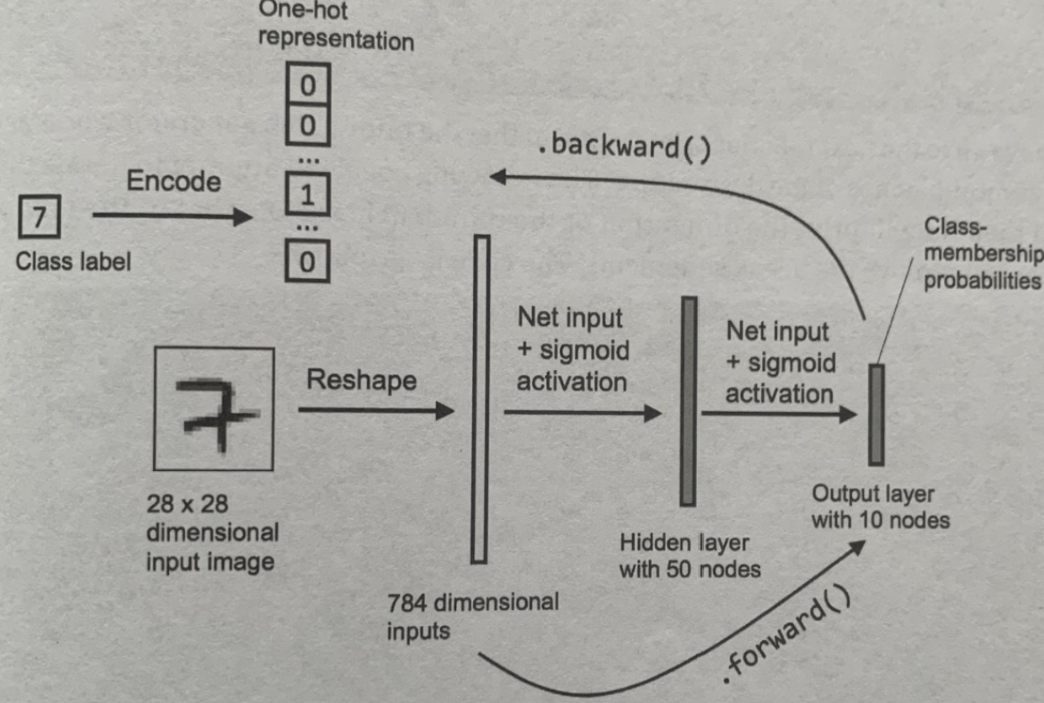

In [8]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

#### The first function we are going to define is a mini-batch generator.  It will take our dataset and divide it into mini-batches  for stochastic gradient descent training. Remember from chapter 2 this means we update the values of weights and bias for every data point incrementally.  This allows us to build our model faster rather than iterating over the entire dataset. 

In [9]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

#### Let's confirm the mini-batch generator works as intended.  

In [10]:
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


#### Now we define our loss function:

In [11]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

#### The textbook goes on to make an improvement with the MSE and accuracy by iterating over the dataset one mini-batch at a time to be more memory efficient.

In [12]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

#### Now we implement the code to train our model

In [13]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h =                 model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

#### Let's execute our model for 50 epochs!

In [14]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)


Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

#### Let's plot the neural network performance.

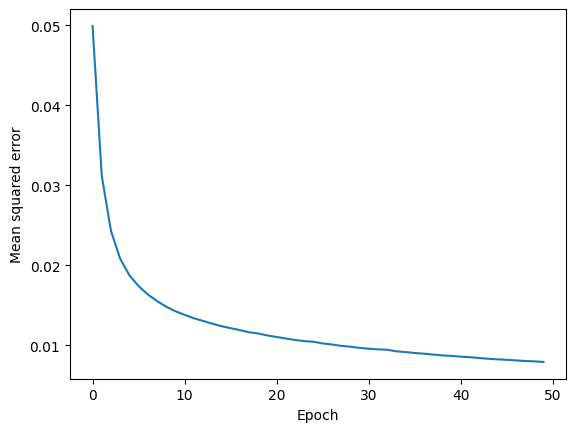

In [15]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

### SUPER IMPORTANT CONCEPT!!!!

It is very useful to compare training and validation accuracy.  You can gauge overfitting by seeing an increasing gap between training and validation performance.  

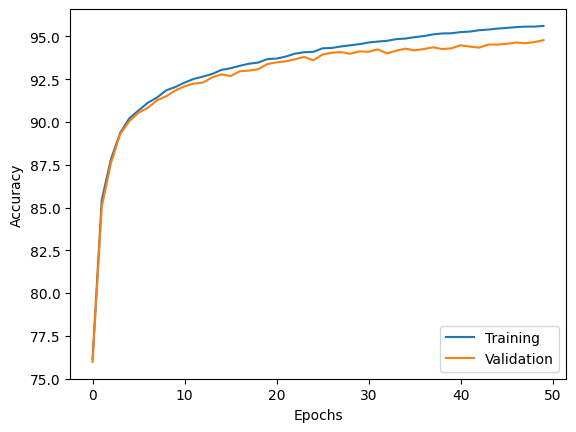

In [16]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()


#### Overtraining after about 25 epochs.

#### And how did we do overall?

In [17]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


#### The remainder of chapter 11 talks through using chain rule to calculate back propagation.  I like this visual CHATGPT gave me better than the textbook

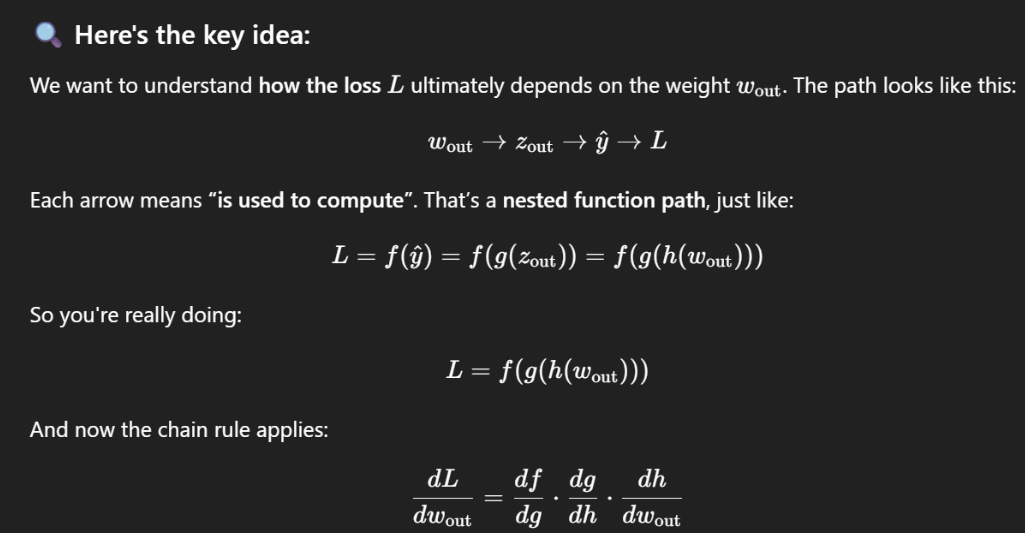

# Pytorch Exercises

PyTorch is an open-source deep learning framework developed by Meta. It provides dynamic computation graphs, making it intuitive and flexible for building neural networks. Widely used in research and industry, PyTorch supports GPU acceleration, automatic differentiation, and extensive tools for model training, deployment, and experimentation across machine learning tasks. We will install version 1.90 to ensure compatibility with the textbook.

#### In terms of backwards compatibility, the textbook wants Torch version 1,90 and torchvision 0.10.  With my version of python, I can't go back that far.  I've installed Pytorch with this command: pip install torch==1.11.0 torchvision==0.12.0  

#### We'll run through some basic familiarization exercises with Pytorch.

In [18]:
import torch
import numpy as np

a = [1, 2, 3]
b = np.array([4, 5, 6], dtype=np.int32)

t_a = torch.tensor(a)
t_b = torch.from_numpy(b)

print(t_a)
print(t_b)

tensor([1, 2, 3])
tensor([4, 5, 6], dtype=torch.int32)


In [19]:
t_ones = torch.ones(2, 3)
t_ones.shape

torch.Size([2, 3])

In [20]:
print(t_ones)

tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [21]:
rand_tensor = torch.rand(2,3)
print(rand_tensor)

tensor([[0.7583, 0.7653, 0.3713],
        [0.4305, 0.8568, 0.2486]])


In [22]:
t_a_new = t_a.to(torch.int64)
print(t_a_new.dtype)

torch.int64


### TRANSPOSING A TENSOR

In [23]:
t = torch.rand(3, 5)
t_tr = torch.transpose(t, 0, 1)
print(t.shape, ' --> ', t_tr.shape)

torch.Size([3, 5])  -->  torch.Size([5, 3])


### RESHAPING A TENSOR (LIKE FROM A 1D VECTOR TO A 2D ARRAY)

In [24]:
t = torch.zeros(30)
t_reshape = t.reshape(5, 6)
print(t_reshape.shape)

torch.Size([5, 6])


### REMOVING UNNECESSARY DIMENSIONS (DIMENSIONS THAT HAVE SIZE 1, WHICH ARE NOT NEEDED)

In [25]:
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = torch.squeeze(t, 2)
print(t.shape, ' --> ', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])


### APPLYING MATHEMATICAL OPERATIONS TO TENSORS

In [26]:
# Element wise multiplication:
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = torch.squeeze(t, 2)
print(t.shape, ' --> ', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])


In [27]:
t1 = 2 * torch.rand(5, 2) - 1
t2 = torch.normal(mean=0, std=1, size=(5, 2))
t3 = torch.multiply(t1, t2)
print(t3)

tensor([[ 0.4455, -0.2601],
        [-0.1728,  0.5885],
        [-0.8114,  0.3159],
        [-0.1458, -0.8855],
        [-0.8592, -0.0285]])


In [28]:
# Compute mean
t4 = torch.mean(t1, axis=0)
print(t4)

tensor([ 0.2963, -0.0613])


In [29]:
# Matrix multiplication
t5 = torch.matmul(t1, torch.transpose(t2, 0, 1))
print(t5)

tensor([[ 0.1854, -0.2648, -0.4185,  0.1094,  0.7529],
        [ 1.6905,  0.4157, -1.5143,  1.2551,  1.0523],
        [ 0.1162, -0.4528, -0.4954,  0.0424,  1.0608],
        [-1.3549, -0.6109,  0.9879, -1.0313, -0.2730],
        [-0.0720,  0.3927,  0.3982, -0.0160, -0.8877]])


In [30]:
# Matrix transpose
t6 = torch.matmul(torch.transpose(t1, 0, 1), t2)
print(t6)

tensor([[-1.5437,  0.6863],
        [ 0.0384, -0.2696]])


In [31]:
# L2 Norm of a tensor (no idea what this is)
norm_t1 = torch.linalg.norm(t1, ord=2, dim=1)
print(norm_t1)

tensor([0.6745, 1.2053, 0.9723, 0.8387, 0.8185])


## SPLIT, STACK, AND CONCATENATE TENSORS

In [32]:
torch.manual_seed(1)
t = torch.rand(6)
print(t)
t_splits = torch.chunk(t, 3)
[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999])


[array([0.7576316 , 0.27931088], dtype=float32),
 array([0.40306926, 0.73468447], dtype=float32),
 array([0.02928156, 0.7998586 ], dtype=float32)]

In [33]:
torch.manual_seed(1)
t = torch.rand(5)
print(t)
t_splits = torch.split(t, split_size_or_sections=[3, 2])
[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293])


[array([0.7576316 , 0.27931088, 0.40306926], dtype=float32),
 array([0.73468447, 0.02928156], dtype=float32)]

In [34]:
A = torch.ones(3)
B = torch.zeros(2)
C = torch.cat([A, B], axis=0)
print(C)

tensor([1., 1., 1., 0., 0.])


In [35]:
A = torch.ones(3)
B = torch.zeros(3)
S = torch.stack([A, B], axis=1)
print(S)

tensor([[1., 0.],
        [1., 0.],
        [1., 0.]])


## CREATING A PYTORCH DATALOADER FROM EXISTING TENSORS

#### Good if data already exists in the form of a tensor object, a python list, or a NumPy array

In [36]:
from torch.utils.data import DataLoader
t = torch.arange(6, dtype=torch.float32)
data_loader = DataLoader(t)
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [37]:
# Create batches
data_loader = DataLoader(t, batch_size=3, drop_last=False)
for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}:', batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


#### Assume that we have two tensors, t_x, and t_y. Tensor t_x holds our feature values and t_y stores the class labels.  Now we want to create a joint dataset. 

In [38]:
from torch.utils.data import Dataset
torch.manual_seed(1)
t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)
class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [39]:
from torch.utils.data import TensorDataset
joint_dataset = TensorDataset(t_x, t_y)
for example in joint_dataset:
    print('  x: ', example[0], 
          '  y: ', example[1])

  x:  tensor([0.7576, 0.2793, 0.4031])   y:  tensor(0)
  x:  tensor([0.7347, 0.0293, 0.7999])   y:  tensor(1)
  x:  tensor([0.3971, 0.7544, 0.5695])   y:  tensor(2)
  x:  tensor([0.4388, 0.6387, 0.5247])   y:  tensor(3)


# BACK TO THE IRIS DATASET

#### In Week 1, we build the model from scratch and applied stochastic gradient descent optimization.  Pytorch provides already defined layers through torch.nn that can be readily used as the building blocks of a neural network model.  Let's use these layers to solve a classification task using the Iris flower dataset.  This time we will distinguish between the three species.

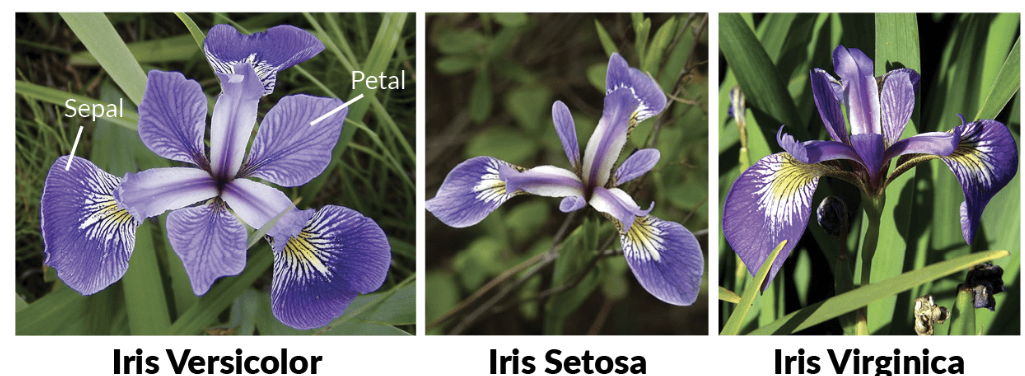

In [40]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

In [41]:
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [42]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 
train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

#### I really like this explanation in the book.

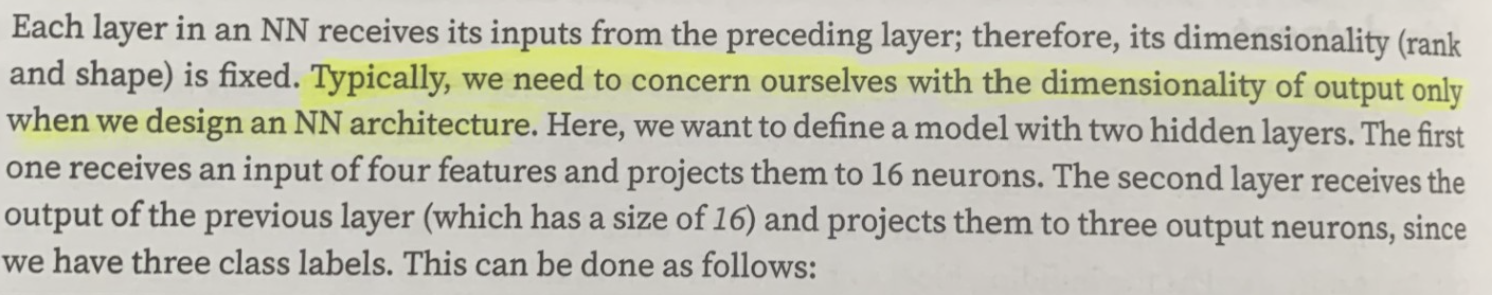

In [43]:
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

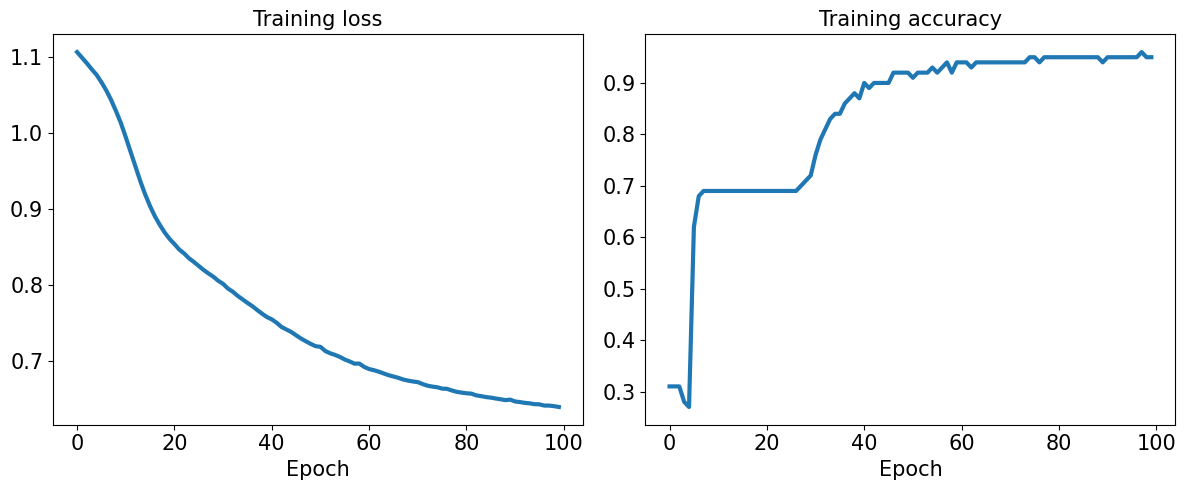

In [45]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


 
plt.show()

## Evaluating the trained model on the test dataset

In [46]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


#### See that!  We did the same work as last week with maybe a quarter of the code.  In the future, on page 399, there are instructions on saving and reloading a trained model.  This would have been helpful for my work in Riyadh. 

In [47]:
path = 'iris_classifier.pt'
torch.save(model, path)

model_new = torch.load(path)
model_new.eval()

pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800
